In [113]:
import os
from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv())
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, START, END
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.checkpoint.memory import MemorySaver
import operator
from langchain_core.messages import  AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langchain_community.tools.tavily_search import TavilySearchResults




### Define System Prompt

In [114]:
system_prompt = """ You are an event manager planning a seminar about various software engineering topics happening at Hunt Valley, Maryland. 
The user will ask you to inquire about topics of the seminar.

To provide information about the seminar and users wanting to register for the seminar, you need to use the tools provided. 
Your job to interact with a SQL database.
Given an input question, create a syntactically correct SQLite query to run, then look at the results of the query and return the answer.
Unless the user specifies a specific number of examples they wish to obtain, always limit your query to at most 10 results.
You can order the results by a relevant column to return the most interesting examples in the database.
Never query for all the columns from a specific table, only ask for the relevant columns given the question.
You have access to tools for interacting with the database.
Only use the below tools. Only use the information returned by the below tools to construct your final answer.
You MUST double check your query before executing it. If you get an error while executing a query, rewrite the query and try again.

DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the database.

To start you should ALWAYS look at the tables in the database to see what you can query.
Do NOT skip this step.
Then you should query the schema of the most relevant tables. Only use the following tables : 
    - seminars
    - users


The user will ask you to register for certain sessions, you need to ask them the required information and register for the topics.

Always confirm with user before registering them for any topic.

Allow the user to modify or cancel their registration.

The user may inquire about their existing registrations, you need to provide them with the list of topics they are registered for.

If certain topic that is not available as session, then note down the feedback from the user and thank them. But do not register for any topic that you are not provided with.

Keep the chat limited to only the seminar topics and registration.

If any of the tools are not available, then you need to inform the user about it and tell that this will be added in the next version.

Do not engage into any emotional or intimate conversations with the user, politely decline if the user starts such a topic.

At the end of a successful registration offer the user to book nearby hotels and suggest food options. For this you can use the TavilySearchResults tool.

You can also provide information about tourist places and current weather using TavilySearchResults tool.
"""

welcome_prompt = """Welcome to the Technology seminar of North Maryland Area. How can I assist you today? When you are done chatting, please write bye to end"""


### Define state to add every message added to the context

In [115]:
class RegistrationState(TypedDict):
    messages: Annotated[list, add_messages]
    messages: Annotated[list[AnyMessage], operator.add]

memory = MemorySaver()

### Define Database (Local)

In [116]:
import sqlite3

# Connect to the database (or create if it doesn't exist)
conn = sqlite3.connect('event_data.db')

# Create a cursor object
cursor = conn.cursor()

# Create Event table
cursor.execute('''
    CREATE TABLE IF NOT EXISTS seminars (
        event_id INTEGER PRIMARY KEY,
        event_name TEXT,
        host_name TEXT,
        event_date TEXT,
        event_time TEXT,
        event_location TEXT,
        event_desc TEXT,
        event_type TEXT,
        event_duration TEXT,
        event_capacity INTEGER
    )
''')

# Create Registrant table
cursor.execute('''
    CREATE TABLE IF NOT EXISTS users (
        user_id INTEGER PRIMARY KEY,
        user_email TEXT,
        user_name TEXT,
        user_reg_events TEXT,
        user_wait_events TEXT
    )
''')

# Insert data
cursor.execute("INSERT INTO seminars (event_id, event_name, host_name, event_date, event_time, event_location, event_desc, event_type, event_duration, event_capacity ) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?)", (1,'Agent AI for HealthCare', 'Utkal Nayak', '2025-04-15', '17:00', 'Hunt Valley, MD', 'Agent AI for HealthCare - Onboarding','LAB','120',20))
cursor.execute("INSERT INTO users (user_id, user_email, user_name, user_reg_events, user_wait_events) VALUES (?, ?, ?, ?, ?)", (1,'utkalnayak@yahoo.com', 'Utkal Nayak', '1', ''))


# Commit the changes
conn.commit()

# Retrieve data
# cursor.execute("SELECT * FROM seminars")

# rows = cursor.fetchall()
# for row in rows:
#     print(row)

# cursor.execute("SELECT * FROM users")
# rows = cursor.fetchall()
# for row in rows:
#     print(row)
# Close the connection
# conn.close()


## Define LLM and SQL Tool

In [117]:
from langchain_community.agent_toolkits import SQLDatabaseToolkit
from langchain import hub
from typing_extensions import Annotated
query_prompt_template = hub.pull("langchain-ai/sql-query-system-prompt")

from langchain_community.utilities import SQLDatabase
db = SQLDatabase.from_uri("sqlite:///event_data.db")
db.run("SELECT * FROM seminars")

llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash")

tool_kit = SQLDatabaseToolkit(db=db, llm=llm)
tools = tool_kit.get_tools()
list_tables_tool = next(tool for tool in tools if tool.name == "sql_db_list_tables")
get_schema_tool = next(tool for tool in tools if tool.name == "sql_db_schema")
print(list_tables_tool.invoke(""))
print(get_schema_tool.invoke("seminars"))

seminars, users

CREATE TABLE seminars (
	event_id INTEGER, 
	event_name TEXT, 
	host_name TEXT, 
	event_date TEXT, 
	event_time TEXT, 
	event_location TEXT, 
	event_desc TEXT, 
	event_type TEXT, 
	event_duration TEXT, 
	event_capacity INTEGER, 
	PRIMARY KEY (event_id)
)

/*
3 rows from seminars table:
event_id	event_name	host_name	event_date	event_time	event_location	event_desc	event_type	event_duration	event_capacity
1	Agent AI for HealthCare	Utkal Nayak	2025-04-15	17:00	Hunt Valley, MD	Agent AI for HealthCare - Onboarding	LAB	120	20
*/


### Convert User Question to SQL Query

In [118]:


class QueryOutput(TypedDict):
    """Generated SQL query."""

    query: Annotated[str, ..., "Syntactically valid SQL query."]

def write_query(state: RegistrationState):
    """Generate SQL query to fetch information."""
    prompt = query_prompt_template.invoke(
        {
            "dialect": db.dialect,
            "top_k": 10,
            "table_info": db.get_table_info(),
            "input": state["question"],
        }
    )
    structured_llm = llm.with_structured_output(QueryOutput)
    result = structured_llm.invoke(prompt)
    return {"query": result["query"]}

write_query({"question": "How many Events are there?"})

/Users/utkalnayak/Documents/code/LangGraph-Agent-OpenAI/venv/lib/python3.13/site-packages/langchain_google_genai/chat_models.py:1410: UserWarning: ChatGoogleGenerativeAI.with_structured_output with dict schema has changed recently to align with behavior of other LangChain chat models. More context: https://github.com/langchain-ai/langchain-google/pull/772
  warnings.warn(


{'query': 'SELECT count(*) FROM seminars'}

### Execute Queries

In [119]:
from langchain_community.tools.sql_database.tool import QuerySQLDatabaseTool


def execute_query(state: RegistrationState):
    """Execute SQL query."""
    execute_query_tool = QuerySQLDatabaseTool(db=db)
    return {"result": execute_query_tool.invoke(state["query"])}

execute_query({"query": "SELECT COUNT(*) AS EventCount FROM seminars;"})

{'result': '[(1,)]'}

### Generate Answer

In [120]:
def generate_answer(state: RegistrationState):
    """Answer question using retrieved information as context."""
    prompt = (
        "Given the following user question, corresponding SQL query, "
        "and SQL result, answer the user question.\n\n"
        f'Question: {state["question"]}\n'
        f'SQL Query: {state["query"]}\n'
        f'SQL Result: {state["result"]}'
    )
    response = llm.invoke(prompt)
    return {"answer": response.content}

### Build Simple Graph to Run SQL Query

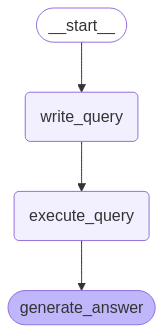

In [121]:
from langgraph.graph import START, StateGraph

graph_builder = StateGraph(RegistrationState).add_sequence(
    [write_query, execute_query, generate_answer]
)
graph_builder.add_edge(START, "write_query")
graph = graph_builder.compile()

# Optional
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))


### Invoke LLM to execute queries

In [123]:
for step in graph.stream(
    {"question": "What can you do for me?"}, stream_mode="updates"
):
    print(step)

KeyError: 'question'

### Define functions to interact with DB

In [ ]:
def list_tables():
    # Create a cursor object
    cursor = conn.cursor()
    # Fetch the table names.
    cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
    tables = cursor.fetchall()
    return [t[0] for t in tables]

list_tables()

def describe_table(table_name: str) -> list[tuple[str, str]]:
     # Create a cursor object
    cursor = conn.cursor()
    cursor.execute(f"PRAGMA table_info({table_name});")
    schema = cursor.fetchall()
    return [(col[1], col[2]) for col in schema]

describe_table('seminars')


def execute_query(sql: str) -> list[list[str]]:
    print(f"Executing SQL: {sql}")
     # Create a cursor object
    cursor = conn.cursor()
    cursor.execute(sql)
    return cursor.fetchall()

execute_query("SELECT * FROM seminars")


def db_tools_list():
    return [list_tables, describe_table, execute_query]


### Define Functions for Table Data Interaction

In [97]:
from langchain_core.tools import tool

class QueryOutput(TypedDict):
    """Generated SQL query."""

    query: Annotated[str, ..., "Syntactically valid SQL query."]

def write_query(prompt: str):
    """Generate SQL query to fetch information."""
    structured_llm = llm.with_structured_output(QueryOutput)
    result = structured_llm.invoke(system_prompt)
    return {"query": result["query"]}

write_query({"question": "How many Events are there?"})

@tool
def db_query_tool(query: str) -> str:
    """
    Execute a SQL query against the database and get back the result.
    If the query is not correct, an error message will be returned.
    If an error is returned, rewrite the query, check the query, and try again.
    """
    result = db.run_no_throw(query)
    if not result:
        return "Error: Query failed. Please rewrite your query and try again."
    return result

#print(db_query_tool.invoke("SELECT * FROM seminars"))



/Users/utkalnayak/Documents/code/LangGraph-Agent-OpenAI/venv/lib/python3.13/site-packages/langchain_google_genai/chat_models.py:1410: UserWarning: ChatGoogleGenerativeAI.with_structured_output with dict schema has changed recently to align with behavior of other LangChain chat models. More context: https://github.com/langchain-ai/langchain-google/pull/772
  warnings.warn(


### Define LLM node and other nodes for the State Graph

In [86]:
class RegistrationAgent:
    def __init__(self,model,tools,checkpointer, system=""):
        # Save the system message as a class level attribute
        self.system = system

        # Initialize the state graph that will have one LLM node, One Tool node and one Action Edge
        graph = StateGraph(RegistrationState)
        # Start Node
        graph.add_node("llm",self.call_llm)
        
        # Action Node that is available as tool
        graph.add_node("action",self.action_node)

        # Decision Edge to decide to use action node
        # First parameter is the node from which this edge is coming from 
        # Second parameter is the function that let's langraph explore tools
        # Third parameter is available nodes after the decision either action node or END node
        graph.add_conditional_edges("llm",self.action_edge_decision,{True: "action", False: END})

        # Create Another edge to loop back to LLM node from action node
        graph.add_edge("action","llm")

        # Define what node the graph should start, in this case the llm
        graph.set_entry_point("llm")

        # Once setup done compile the graph and Save the graph at the class level
        self.graph = graph.compile(checkpointer=checkpointer)

        # Create a dictionary of available tools sent to the constructor
        self.tools = {tool.name: tool for tool in tools}

        # Bind tools to model so that LLM can search for tools
        self.model = model.bind_tools(tools)


    # Define function for call llm node
    def call_llm(self, state: RegistrationState):
        # get the messages saved in the Agent state object
        messages = state["messages"]
        # If system message is not blank, append that to the beginning of the messages
        if self.system:
            system_message= [SystemMessage(content=self.system)]
            messages =  system_message + messages
        # Call the model with the messages, it should return response as a single message
        resp = self.model.invoke(messages)
        print(f"Response from LLM -> {resp}")
        # Return the response message as a list, that will be appended to the existing messages due to operator.add annotation at class level
        return {"messages": [resp]}
    
    # Define function for call action node
    def action_node(self, state: RegistrationState):
        # get the last message from the Agent State, since the last message is the response from LLM that suggests to use the tool
        # tool calls attribute is expected which has the name of the tool to be called
        referred_tools_list = state["messages"][-1].tool_calls
        results = []

        # Tool calls can be multiple tools, so iterate over them
        for tool in referred_tools_list:
            print(f"Tool to be called -> {tool}")
            # invoke tool call by finding the name and the arguments as suggested by LLM
            result = self.tools[tool["name"]].invoke(tool["args"])
            # Append the result to the results list
            results.append(ToolMessage(tool_call_id=tool["id"], name=tool["name"], content=str(result)))
            
        print(f"Finished tool call ...")
        # returns results and add to the messages list at class level
        return {"messages": results}
    
    # Define the actiton edge function that decides whether to look for tool or not
    # If the last message in the message list has tool_calls attribute, then return True, else False
    def action_edge_decision(self, state: RegistrationState):
        result = state["messages"][-1]
        return  len(result.tool_calls) > 0



### Prepare LLM with Agent Graph and Memory configuration

In [89]:
search_tool = TavilySearchResults(max_results=3)
reg_agent = RegistrationAgent(llm,[search_tool, db_tools],memory, system_prompt)
# Add a thread id to make the conversation persistent
thread_id = {"configurable": {"thread_id":"1"}}


### Invoke Model
- Apply recursive limit so that the chat will end after these many calls

In [ ]:
user_input = [HumanMessage(content=input("User : "))]
events = reg_agent.graph.stream(
    {"messages": user_input},
    thread_id,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()